In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True

In [24]:
example_year = pd.read_csv("../data/Luftemissionen_1995.csv", delimiter=";")
example_year

,year,economic_sector,Kohlendioxid (CO2),Methan (CH4),Distickstoffmonoxid (N2O),Stickoxide (NOx),Schwefeldioxid (SO2),Flüchtige Kohlenwasserstoffe ohne Methan (NMVOC),Ammoniak (NH3),Feinstaub (10 µm),Hydrofluorocarbon (HFC),Perfluorocarbon (PFC),Schwefelhexafluorid (SF6)
0,1995,Erz.d. Landwirtschaft u. Jagd sowie damit verb...,16801097,1465896,97980,177694,14471,249524,636611,50767,0,0,0
1,1995,Forstwirtschaftl. Erzeugnisse und Dienstleistu...,492779,1105,7,2093,134,14869,1,404,0,0,0
2,1995,"Fische und Fischereierz., Aquakulturerz., DL",54261,1,2,678,258,37,0,248,0,0,0
3,1995,Kohle,1752124,772889,15,1762,3135,2153,11,6190,0,0,0
4,1995,Erdöl und Erdgas,2936879,7847,14,1418,332,925,3,25,0,0,0
5,1995,"Erze, Steine und Erden, sonstige Bergbauerz., DL",1747172,94,2221,2634,2216,158,17,15493,0,0,0
6,1995,"Nahrungs- u. Futtermittel, Getränke, Tabakerze...",11382261,764,214,15300,16289,16945,193,983,0,0,0
7,1995,"Textilien, Bekleidung, Leder und Lederwaren",2423522,174,44,2920,2260,166,30,118,0,0,0
8,1995,"Holz,Holz- u.Korkwaren (oh.Möbel),Flecht- u.Ko...",5497789,1916,55,2950,2289,8102,77,2105,0,0,0
9,1995,"Papier, Pappe und Waren daraus",11553707,992,238,11360,11452,1449,99,1006,0,0,0


In [131]:
def calc_total_emissions(df):
    gasses = ["Kohlendioxid (CO2)", "Methan (CH4)", "Distickstoffmonoxid (N2O)", "Flüchtige Kohlenwasserstoffe ohne Methan (NMVOC)", "Feinstaub (10 µm)"]
    new_cols = ["economic_sector"] + gasses
    analyzed_df = df[new_cols]
    analyzed_df["total_emissions"] = df[gasses].sum(axis=1)
    analyzed_df["excluded_emissions"] = calc_excluded_emissions(df)
    new_col_order = ["economic_sector", "total_emissions", "excluded_emissions"] + gasses
    analyzed_df = analyzed_df[new_col_order]
    analyzed_df = analyzed_df.sort_values(by="total_emissions", ascending=False)
    return analyzed_df

def calc_excluded_emissions(df):
    excluded_gasses = ["Stickoxide (NOx)", "Schwefeldioxid (SO2)", "Ammoniak (NH3)", "Hydrofluorocarbon (HFC)", "Perfluorocarbon (PFC)", "Schwefelhexafluorid (SF6)"]
    return df[excluded_gasses].sum(axis=1)

def calc_proportions(df):
    # emission from all sectors, from only included 5 gasses
    total_year_emission = df["total_emissions"].sum()
    # emission from all sectors, from excluded gasses
    total_excluded_year_emission = df["excluded_emissions"].sum()
    # all of the emissions in a year, from all gasses
    total = total_year_emission + total_excluded_year_emission
    df["proportions"] = (df["total_emissions"] / total).round(2)
    df["excluded_proportions"] = (df["excluded_emissions"] / total).round(2)
    return total_year_emission

def add_others_sector(df, rank=6):
    num_sectors = len(df)
    others_df = df.tail(num_sectors - rank)
    sums = others_df.drop(columns=["economic_sector"]).sum()
    others_row = pd.DataFrame(data={'economic_sector': ['Others'], **sums.to_dict()})
    df_with_others = pd.concat([df.head(rank), others_row], ignore_index=True)
    df_with_others = df_with_others.sort_values(by="total_emissions", ascending=False)
    return df_with_others



In [132]:
smaller_df = calc_total_emissions(example_year)
df_to_analyze = add_others_sector(smaller_df, 6)
calc_proportions(df_to_analyze)

np.int64(993713568)

In [133]:
def plot_year_most_emitters(df):
    sns.set_style("white")
    palette = sns.color_palette("cubehelix")
    plt.figure(figsize=(12, 7))
    bar_plot = sns.barplot(x='economic_sector', y='proportions', hue="economic_sector",
                           palette=palette, data=df, errorbar=None)
    bar_plot.set_title('Proportions of Emissions by Economic Sector', fontsize=16)
    bar_plot.set_xlabel('Economic Sector', fontsize=14)
    bar_plot.set_ylabel('Proportion of Total Emissions', fontsize=14)
    bar_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.xticks(rotation=0, ha='right')
    sns.despine()
    plt.tight_layout()
    plt.show()

C:\Users\asude\AppData\Local\Temp\ipykernel_28624\122820495.py:5: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  bar_plot = sns.barplot(x='economic_sector', y='proportions', hue="economic_sector", palette=palette, data=df, errorbar=None)


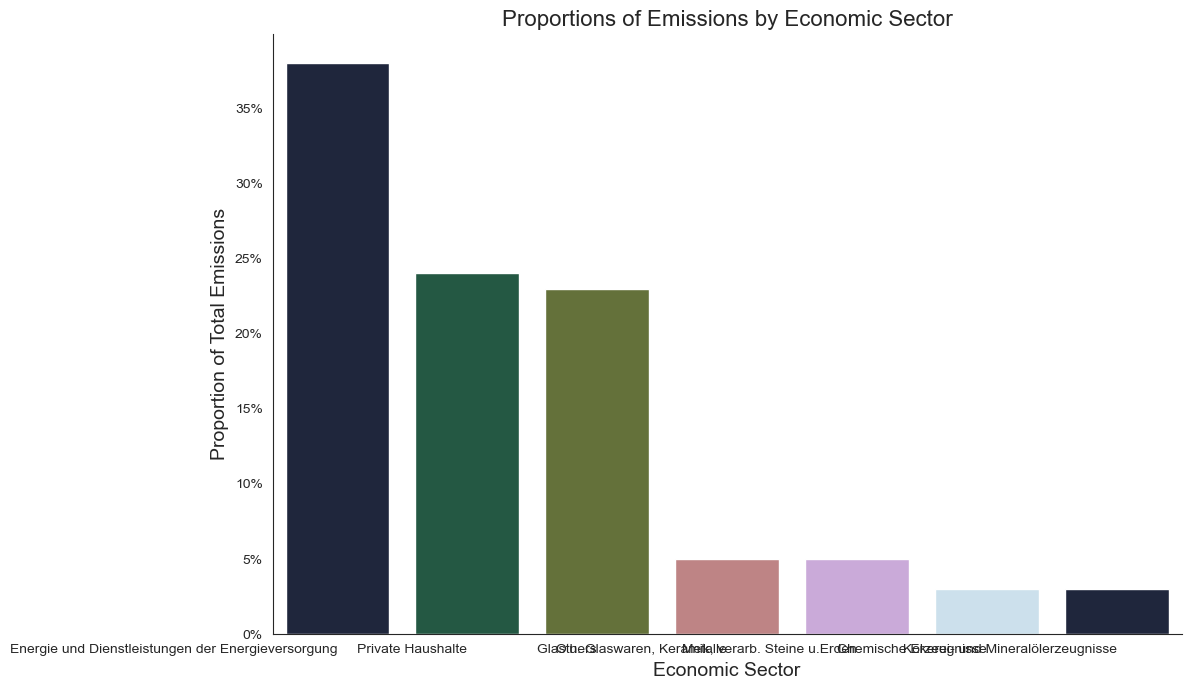

In [134]:
plot_year_most_emitters(df_to_analyze)

In [158]:
from textwrap import wrap

def visualize(df):
    sns.set_style("white")
    palette = sns.color_palette("cubehelix")
    catp = (sns.catplot(data=df, x='economic_sector', y='proportions',
                    kind='bar',
                    hue="economic_sector",
                    palette=palette,
                    height=5,
                    aspect=19/6)
        .set(xlabel="Economic Sectors",
             ylabel="Proportion",
             title="\n".join(wrap("Proportional Contribution of Each Sector to Total Air Emissions", 90))))
    
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))

    for ax in catp.axes.ravel():
        labels = ax.get_xticklabels()
        for v in labels:
            text = v.get_text()
            text = '\n'.join(wrap(text, 30))
            v.set_text(text)
        ax.set_xticklabels(labels)
        for c in ax.containers:
            ax.bar_label(c, label_type='edge')


C:\Users\asude\AppData\Local\Temp\ipykernel_28624\2696684964.py:6: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  catp = (sns.catplot(data=df, x='economic_sector', y='proportions',
C:\Users\asude\AppData\Local\Temp\ipykernel_28624\2696684964.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


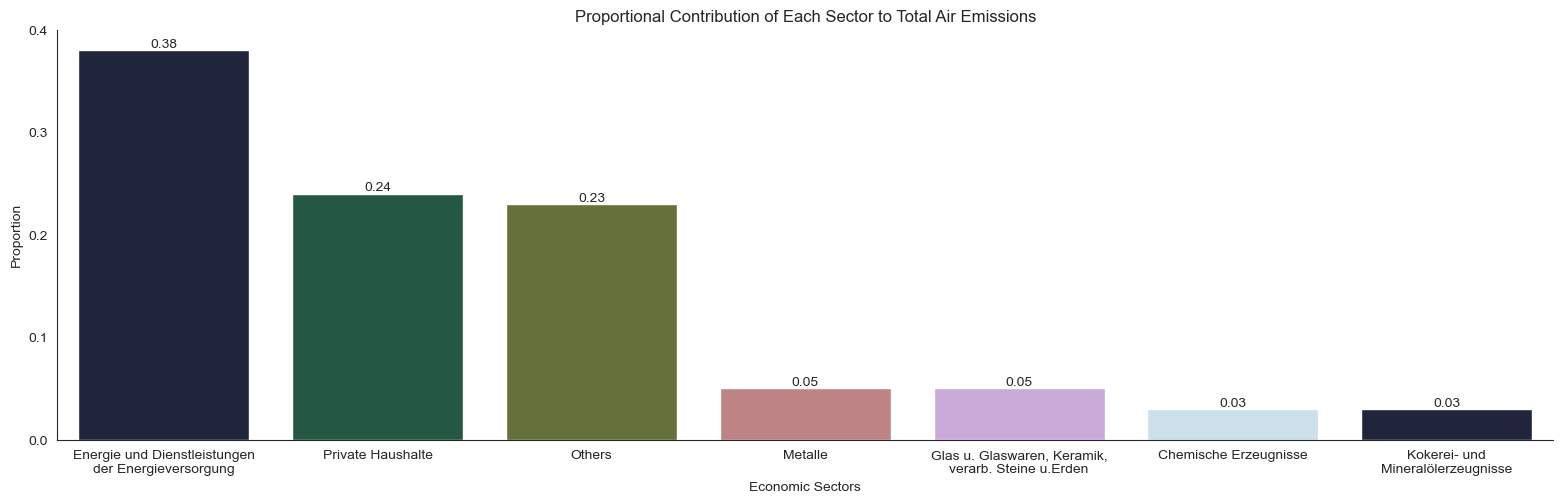

In [160]:
visualize(df_to_analyze)